In [1]:
# import libraries for time-series analysis
import os
import numpy as np
import pandas as pd
import seaborn as sns

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt
from matplotlib import cm
from pandas import read_csv, set_option

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
import xgboost
from xgboost import plot_importance, XGBClassifier, XGBRegressor
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import shap

from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from tqdm.autonotebook import tqdm
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import FastICA
from sklearn.manifold import Isomap
from sklearn.manifold import MDS
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection

import time
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
%matplotlib inline

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### 1. Data Cleaning and Preparation
* 1.1 Reset Index for Time-Series Modelling 
<br> 
* 1.2 Train / Test Split
<br> 
* 1.2 Handle Missing Values
<br>
* 1.3 Creating New Variables (SMA, LMA) using rolling  + apply Cross-Over Strategy to determine Buy / Sell Signals (Target Variable)

In [2]:
# import the csv file 
path = './data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'
df_raw = pd.read_csv(path)

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


In [3]:
# examine the data
df_raw.head(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1325318220,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1325318280,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1325318340,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1325318400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1325318460,NaN,NaN,NaN,NaN,NaN,NaN,NaN


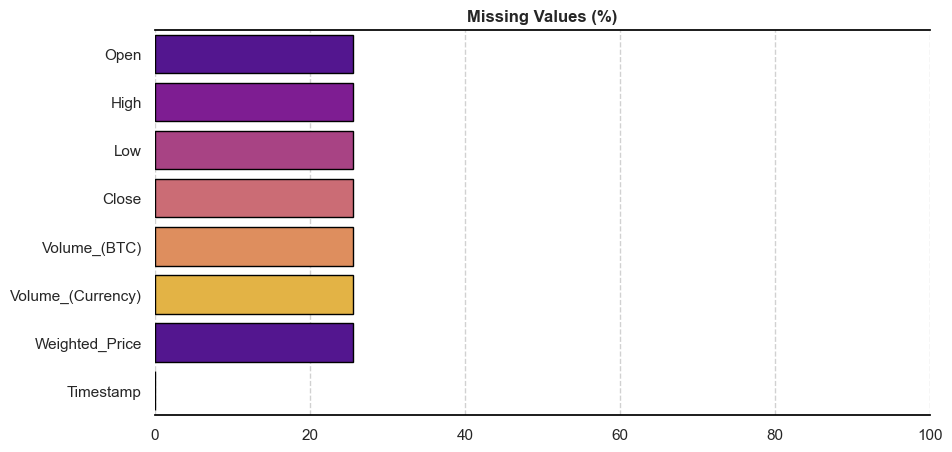

In [4]:
# make sure not all values are NaN before cleaning dataset
NaN_values = (df_raw.isnull().sum()/len(df_raw)*100).sort_values(ascending=False)

# custom function for plotting missing values
def bar_plot(x,
             y, 
             palette_len, 
             title = 'Missing Values (%)',
             xlim = None, 
             ylim = None, 
             xticklabels = None, 
             yticklabels = None,
             xlabel = None, 
             ylabel = None, 
             figsize = (10, 4), 
             axis_grid = 'y'):
    
    cmap = sns.color_palette('plasma')
    fig, ax = plt.subplots(figsize = figsize)
    plt.title(label = 'Missing Values (%)', fontweight = 'bold')
    
    for i in ['top', 'right', 'bottom', 'left']:
        ax.spines[i].set_color('black')
        
    ax.spines['top'].set_visible(True);
    ax.spines['right'].set_visible(False);
    ax.spines['bottom'].set_visible(True);
    ax.spines['left'].set_visible(False);
    
    sns.barplot(x = x,
                y = y,
                edgecolor = 'black',
                ax = ax,
                palette = cmap)
    
    ax.set_xlim(xlim);
    ax.set_ylim(ylim);
    ax.set_xticklabels(xticklabels);
    ax.set_yticklabels(yticklabels);
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    ax.grid(axis = axis_grid,
            ls = '--',
            alpha = 0.9)
    
    plt.show();


# bar plotting missing data values
bar_plot(x = NaN_values,
         y = NaN_values.index,
         palette_len = NaN_values.index,
         xlim = (0, 100),
         xticklabels = range(0, 101, 20),
         yticklabels = NaN_values.index,
         figsize = (10, 5),
         axis_grid = 'x')

#### 1.1. Reset index to datetime for Time-Series Modelling

In [5]:
import pytz
import datetime

In [6]:
# define time conversion custom function for native timestamps in the csv file
def datetime_parser(time_in_secs):
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

# for time series data, the datetime is always the index
df = pd.read_csv(path,
                parse_dates=[0], # to be decided later
                date_parser = datetime_parser,
                index_col = 'Timestamp')    

In [7]:
# examine df
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4857377 entries, 2011-12-31 15:52:00+00:00 to 2021-03-31 08:00:00+00:00
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Open               float64
 1   High               float64
 2   Low                float64
 3   Close              float64
 4   Volume_(BTC)       float64
 5   Volume_(Currency)  float64
 6   Weighted_Price     float64
dtypes: float64(7)
memory usage: 296.5 MB


In [8]:
df

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 15:52:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2011-12-31 15:53:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 15:54:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 15:55:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 15:56:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-03-31 07:56:00+00:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
2021-03-31 07:57:00+00:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
2021-03-31 07:58:00+00:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496


#### 1.2 Train / Test Time-Series Split

In [9]:
# select a subset of data to train models on, due to limitations in GPU and extent of missing data
# note that the resulting model would be limited as some trends would be missed
# use only 1,000,000 data points that are most relevant to what we want to predict in the future
# train/test split (0.8/0.2)


# create function for slicing data (specific time period) and then splitting them into training and testing datasets
def TimeSeries_Split(ldf,
                    split_id = [None, None],
                    test_id = False,
                    cut_id = None):
    # part 1: reduce the number of used data 
    if (cut_id is not None):
        print('Reducing Input Data')
        
        if (type(cut_id) is int):
            ldf = ldf.iloc[-cut_id:]
        else:
            # when cut_id is anything other than int
            print('Slicing Based on Period')
            ldf = ldf[data_period]
            
        t1 = ldf.index.max();
        t0 = ldf.index.min();
        print(f'Dataset Min.Index: {t0} | Max.Index: {t1}')
    
    # part 2: general percentage split (do not shuffle data for time series) 
    if (split_id[0] is not None):
        # general percentage split without shuffling for time series
        train_df, pred_df = train_test_split(ldf, 
                                             test_size=split_id[0], 
                                             shuffle=False)
    elif(split_id[1] is not None):
        # specific time split
        train_df = df.loc[:split_id[1]]; # consists of x_train, y_train
        pred_df = df.loc[split_id[1]:]; # consists of x_test, y_test
    else:
        print('Error: Choose One Splitting Method Only')
        
    return train_df, pred_df

# select data_period for training and testing - 1/5 of original dataset (5,000,000 entries)
data_period = slice('2018-9-14 13:21', '2020-9-14 0:00')

# implement custom function
train_df, test_df = TimeSeries_Split(df,
                                     split_id = [0.2, None],
                                     cut_id = data_period)

Reducing Input Data
Slicing Based on Period
Dataset Min.Index: 2018-09-14 13:21:00+00:00 | Max.Index: 2020-09-14 00:00:00+00:00


In [10]:
len(train_df) + len(test_df) 

1051840

#### 1.2 Handle Missing Values
Missing values still exist in train and test datasets. Remove missing values. 

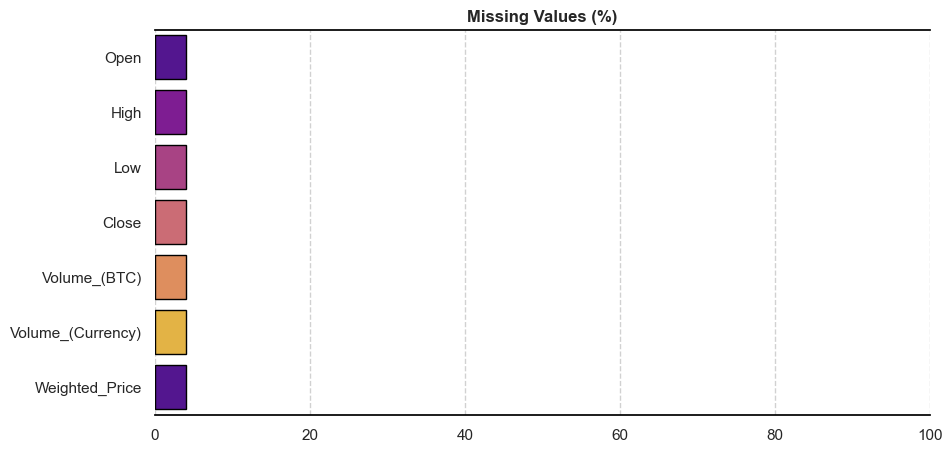

In [11]:
# visualize missing values in training dataset
NaN_values = (train_df.isnull().sum()/len(train_df)*100).sort_values(ascending=False)

# bar plotting missing data values
bar_plot(x = NaN_values,
         y = NaN_values.index,
         palette_len = NaN_values.index,
         xlim = (0, 100),
         xticklabels = range(0, 101, 20),
         yticklabels = NaN_values.index,
         figsize = (10, 5),
         axis_grid = 'x')

In [12]:
# approximately 4% of the training data are missing - to be removed and forward filled since you are dealing with time-series data
NaN_values

Open                 4.053135
High                 4.053135
Low                  4.053135
Close                4.053135
Volume_(BTC)         4.053135
Volume_(Currency)    4.053135
Weighted_Price       4.053135
dtype: float64

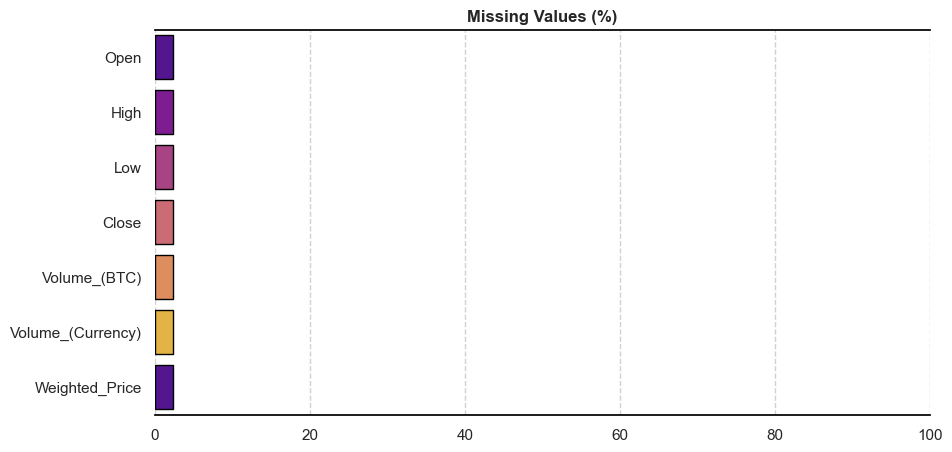

In [13]:
# visualize missing values in test dataset
NaN_values = (test_df.isnull().sum()/len(test_df)*100).sort_values(ascending=False)

# bar plotting missing data values
bar_plot(x = NaN_values,
         y = NaN_values.index,
         palette_len = NaN_values.index,
         xlim = (0, 100),
         xticklabels = range(0, 101, 20),
         yticklabels = NaN_values.index,
         figsize = (10, 5),
         axis_grid = 'x')

In [14]:
train_df[train_df.isna().any(axis=1)]

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2018-09-14 14:14:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-14 14:22:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-14 14:29:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-14 14:54:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-14 15:26:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2020-04-20 17:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-20 17:28:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-20 18:04:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# approximately 2% of the test data are missing - to be removed and forward filled since you are dealing with time-series data
NaN_values

Open                 2.276487
High                 2.276487
Low                  2.276487
Close                2.276487
Volume_(BTC)         2.276487
Volume_(Currency)    2.276487
Weighted_Price       2.276487
dtype: float64

In [16]:
test_df[test_df.isna().any(axis=1)]

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2020-04-21 00:56:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-21 01:01:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-21 06:02:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-21 07:28:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-21 08:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2020-09-13 15:39:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-13 15:43:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-13 15:45:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# create custom function to remove missing values and forward fill
def forward_fill_na(ldf):
    ldf['Volume_(BTC)'].fillna(method='ffill', inplace=True)
    ldf['Volume_(Currency)'].fillna(method='ffill', inplace=True)
    ldf['Weighted_Price'].fillna(method='ffill', inplace=True)
    ldf['Open'].fillna(method='ffill', inplace=True)
    ldf['High'].fillna(method='ffill', inplace=True)
    ldf['Low'].fillna(method='ffill', inplace=True)
    ldf['Close'].fillna(method='ffill', inplace=True)
    
forward_fill_na(train_df)  # modification of training set
forward_fill_na(test_df) # modification of test set

# forward fill / backward fill might not be the most reliable methods
# consider possible alternatives such as linear interpolation and statistical imputation to replace missing data. 

In [18]:
# training dataset after removing NaN
train_df

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2018-09-14 13:21:00+00:00,6557.99,6558.00,6553.41,6558.00,5.088553,33369.066173,6557.673402
2018-09-14 13:22:00+00:00,6553.42,6558.00,6553.42,6558.00,5.528270,36254.256965,6557.974796
2018-09-14 13:23:00+00:00,6558.00,6561.40,6553.46,6561.27,6.201157,40676.341620,6559.476633
2018-09-14 13:24:00+00:00,6561.99,6562.84,6558.51,6561.37,4.956785,32521.373020,6560.981681
2018-09-14 13:25:00+00:00,6561.37,6561.37,6556.30,6556.30,0.123119,807.684619,6560.179310
...,...,...,...,...,...,...,...
2020-04-20 21:48:00+00:00,7060.00,7060.00,7054.82,7054.82,0.133626,942.758431,7055.192035
2020-04-20 21:49:00+00:00,7054.58,7056.06,7048.15,7051.29,0.499422,3521.792672,7051.741246
2020-04-20 21:50:00+00:00,7046.90,7051.46,7045.64,7051.44,0.665439,4691.997514,7050.983936


In [19]:
# test dataset after removing NaN
test_df

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2020-04-20 21:53:00+00:00,7039.33,7039.33,7035.21,7039.32,4.522570,31819.003023,7035.602807
2020-04-20 21:54:00+00:00,7039.37,7039.37,7034.75,7034.75,0.963378,6781.511739,7039.307657
2020-04-20 21:55:00+00:00,7036.17,7044.12,7036.17,7042.32,5.046746,35518.070308,7037.816028
2020-04-20 21:56:00+00:00,7040.39,7040.39,7034.89,7034.89,2.025296,14258.736698,7040.322109
2020-04-20 21:57:00+00:00,7032.95,7037.83,7032.95,7033.47,0.041853,294.479435,7036.108498
...,...,...,...,...,...,...,...
2020-09-13 23:56:00+00:00,10279.29,10292.61,10279.29,10285.41,0.181636,1868.656562,10287.928082
2020-09-13 23:57:00+00:00,10291.04,10296.02,10285.71,10290.16,0.696823,7173.458832,10294.518533
2020-09-13 23:58:00+00:00,10290.16,10290.16,10285.38,10285.38,0.131010,1347.995182,10289.227416


In [20]:
test_df.describe()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,210368.000000,210368.000000,210368.000000,210368.000000,210368.000000,2.103680e+05,210368.000000
mean,9856.180888,9860.581880,9852.054006,9856.347223,5.846117,5.719025e+04,9856.675240
std,1185.749680,1186.386227,1185.472096,1185.856753,17.611059,1.704958e+05,1186.026191
min,6768.370000,6786.850000,6757.750000,6768.810000,0.000003,3.107264e-02,6767.469516
25%,9169.357500,9171.857500,9166.840000,9169.450000,0.214685,2.089489e+03,9169.794399
50%,9512.865000,9516.780000,9509.510000,9513.215000,1.308487,1.293473e+04,9513.187468
75%,10986.152500,10991.595000,10980.305000,10986.372500,4.945037,4.860420e+04,10986.268123
max,12450.910000,12473.000000,12436.310000,12461.680000,1098.349384,1.044599e+07,12457.503516


In [21]:
# statistics on dataset
# round off to 2 decimal places
pd.set_option('display.precision', 2)

#### 1.3 Setting the Target Variable (Signal) for Buy/Sell/Hold Moving Average Crossover Strategy
(1) Short-Term Moving Average (SMA) with window value of 20
<br>
(2) Long-Term Moving Average (LMA2) with window value of 50 

- If the SMA > LMA (20-day SMA crosses over 50-day SMA), the signal value will be 1 (BUY) because indication that actual prices are trending upward (bullish signal), faster than the historical average, suggesting increased buying interest and momentum.
- If the SMA < LMA (20-day SMA crosses below 50-day SMA), the signal value will be 0 (SELL) because indication that actual prices are trending downward (bearish signal), faster than the historical avaerage, suggesting increased selling pressure. 

In [22]:
train_df.describe()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,841472.00,841472.00,841472.00,841472.00,8.41e+05,8.41e+05,841472.00
mean,7112.02,7116.17,7107.90,7111.87,5.93e+00,4.19e+04,7112.18
std,2411.63,2413.75,2409.45,2411.42,1.65e+01,1.24e+05,2411.72
min,3124.45,3131.86,3122.28,3124.45,1.00e-08,3.40e-05,3124.04
25%,5146.58,5148.64,5144.25,5146.46,2.30e-01,1.57e+03,5146.56
50%,7191.32,7195.17,7187.68,7191.43,1.31e+00,8.66e+03,7191.65
75%,9021.27,9027.62,9014.57,9020.87,5.19e+00,3.42e+04,9021.01
max,13853.25,13880.00,13830.06,13850.57,9.64e+02,7.57e+06,13841.52


In [23]:
# note that the window values are arbitary and an optimization study should be conducted to find the optimum values

In [24]:
# customized function to create target variable (buy/sell signal)
def create_target(ldf, tr_id = False):
    # create new column for 20-day short simple moving average window
    ldf['SMA'] = ldf['Close'].rolling(window=20, min_periods=1, center=False).mean() 
    
    # create new column for 50-day long simple moving average window
    ldf['LMA'] = ldf['Close'].rolling(window=50, min_periods=1, center=False).mean() 
    
    # create signal values using condition
    ldf['Signal'] = np.where(ldf['SMA'] > ldf['LMA'], 1.0, 0.0)
    if (tr_id is not True):
        display(ldf['Signal'].value_counts()) # conditional display of signal value_counts, provides flexibility in the function's usage depending on the context (training or testing) 
        

In [25]:
train_df1 = train_df.copy()  # save the baseline model dataframe [training set]
create_target(train_df1) # during training or for the sake of analysis, you want to ensure that distribution of signals is void of imbalances

Signal
1.0    427037
0.0    414435
Name: count, dtype: int64

In [26]:
test_df1 = test_df.copy() # save the baseline model dataframe [test set]
create_target(test_df1, True) # during testing or production, not necessary to display signal distribution

In [27]:
# save baseline model train dataset as a csv file
train_df.to_csv('./data/original_train.csv', index=True)

In [28]:
# save baseline model test dataset as a csv file
test_df.to_csv('./data/original_test.csv', index=True)

In [29]:
# save train_df1 for analysis
train_df1.to_csv('./data/train_df1.csv', index=True)

In [30]:
# save test_df1 for analysis
test_df1.to_csv('./data/test_df1.csv', index=True)

Findings: 
- Relatively balanced buy/sell (420k/410k) target variable signal distribution.
- No need to address issues pertaining to class imbalances.
- Simple metrics such as accuracy, recall, precision would suffice as classification metrics. No need for complex performance metrics such as ROC and PR curves of classifier models. 